# Ultimate Challenge - Taxi & Logistics

Please see the link below for a description of the raw data and the problem of interest:


In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Part 1. Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. We will aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. We will report/illustrate important features of the demand, such as daily cycles. We will also report any data quality issues.

## Import and Wrangle Data

In [2]:
# Read in data
with open('logins.json') as f:
    data = json.load(f)

login = pd.DataFrame(data)

In [21]:
login.info()
login.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 6 columns):
count          9788 non-null int64
month          9788 non-null int64
week           9788 non-null int64
day            9788 non-null int64
hour           9788 non-null int64
day_of_week    9788 non-null int64
dtypes: int64(6)
memory usage: 855.3 KB


,count,month,week,day,hour,day_of_week
login_time,,,,,,
1970-01-01 20:00:00,2,1,1,1,20,3
1970-01-01 20:15:00,6,1,1,1,20,3
1970-01-01 20:30:00,9,1,1,1,20,3
1970-01-01 20:45:00,7,1,1,1,20,3
1970-01-01 21:00:00,1,1,1,1,21,3


In [4]:
login.describe()

,login_time
count,93142
unique,92265
top,1970-01-06 21:45:52
freq,3


In [5]:
login.login_time.value_counts().head(10)

1970-01-06 21:45:52    3
1970-03-17 01:01:39    3
1970-01-09 01:31:25    3
1970-03-14 17:45:52    3
1970-03-29 03:24:57    3
1970-04-12 04:03:15    3
1970-02-12 11:16:53    3
1970-02-24 23:09:57    3
1970-04-04 01:17:40    3
1970-04-04 05:53:47    2
Name: login_time, dtype: int64

There are no missing values in the logins.json file, but there are several duplicate timestamps as seen above.  We are not sure how the data was collected and, as of now, unable to determine if the duplicates are valid entries or not.  We will treat them as valid for now.

In [6]:
# Convert login_time column to datetime and sort in ascending order
login['login_time'] = pd.to_datetime(login.login_time, format="%Y-%m-%d")
login = login.sort_values('login_time')
login.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


The original dataset was not ordered by the timestamp, but we fixed it.

## Aggregate Login Counts Based on 15-Minute Intervals

In [7]:
login['count'] = 1

# Set login_time as the DateTime index
login = login.set_index('login_time')

In [8]:
# Resample login counts based on 15-minute time intervals
login = login.resample('15T').sum()

In [17]:
login.head()

,count,month,week,day,hour,day_of_week
login_time,,,,,,
1970-01-01 20:00:00,2,1,1,1,20,3
1970-01-01 20:15:00,6,1,1,1,20,3
1970-01-01 20:30:00,9,1,1,1,20,3
1970-01-01 20:45:00,7,1,1,1,20,3
1970-01-01 21:00:00,1,1,1,1,21,3


## Visualize Login Trends/Patterns

### Histogram

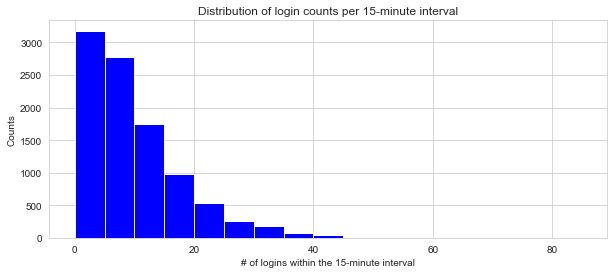

In [16]:
# Plot distribution of login counts per 15-minute interval
plt.figure(figsize=(10,4))
login['count'].plot(kind='hist',
                    bins=np.arange(0,90,5),
                    color='blue',
                    title='Distribution of login counts per 15-minute interval')

plt.xlabel("# of logins within the 15-minute interval")
plt.ylabel("Counts")
plt.show()

Most login counts at 15-minute intervals range between 0-20.

### Plot Time Series Data

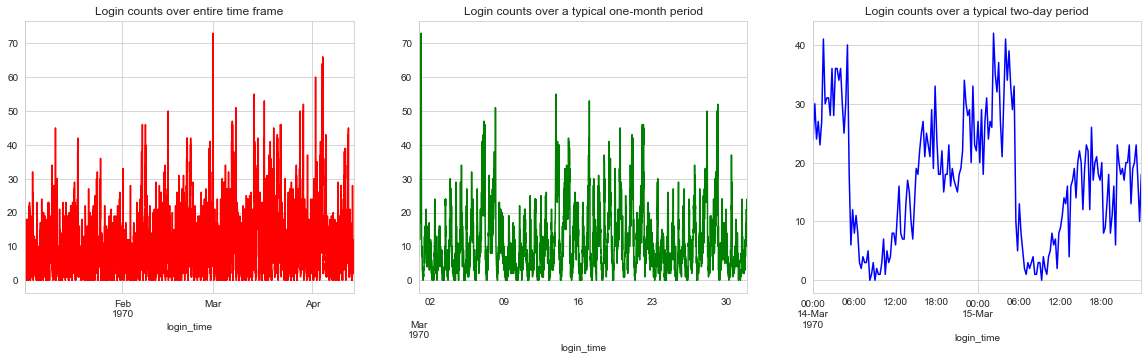

In [11]:
# Plot time series data
plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,3,1)
login.plot(ax=ax1,
           color='red',
           title='Login counts over entire time frame',legend=False)

ax2 = plt.subplot(1,3,2)
login['1970-03'].plot(ax=ax2,
                      color='green',
                      title='Login counts over a typical one-month period',legend=False)

ax3 = plt.subplot(1,3,3)
login['1970-03-14':'1970-03-15'].plot(ax=ax3,
                                      color='blue', 
                                      title='Login counts over a typical two-day period',legend=False)

plt.show()

The time series trends of login counts at 15-minute intervals shows a clear daily, weekly and monthly cycle.  We'll take a closer look into this.

### Investigating Cyclic Patterns

In [12]:
# Retrieve time features from datetime index
login['month'] = login.index.month
login['week'] = login.index.week
login['day'] = login.index.day
login['hour'] = login.index.hour
login['day_of_week'] = login.index.dayofweek

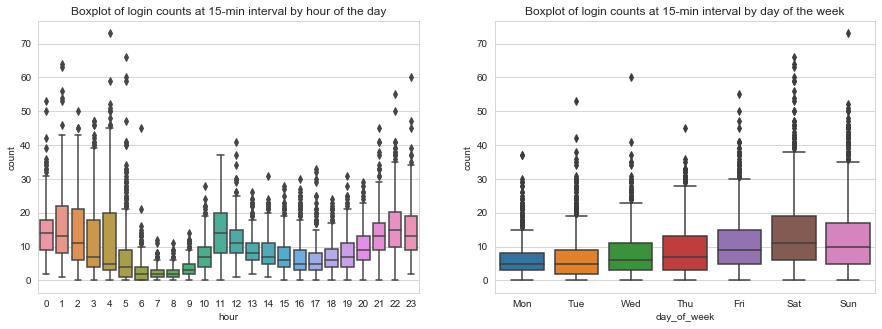

In [13]:
# Display boxplot showing daily/weekly cycles

plt.figure(figsize=(15,5))

# Plot daily cycles
ax1 = plt.subplot(1,2,1)
sns.boxplot(x='hour',y='count',data=login,ax=ax1)
ax1.set_title('Boxplot of login counts at 15-min interval by hour of the day')

# Plot weekly cycles
ax2 = plt.subplot(1,2,2)
sns.boxplot(x='day_of_week',y='count',data=login,ax=ax2)
ax2.set_title('Boxplot of login counts at 15-min interval by day of the week')
ax2.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.show()

The login counts do show a cyclic pattern:
- Daily pattern: the login counts at 15-minute intervals start the day off at its lowerst, 6am to 9am and then start to peak around 11am to 12pm, it slowly lowers but then starts to peak again around 9am to 1am, where it slowly starts to fall to the daily low starting at 6am again.  There are some outliers, let's see if it is caused by type of day.

- Day of the week: the login counts at 15-minute intervals are at its lowest on Monday and gradually rises to its peak on Saturday and starts to lower again on Sunday.  It is safe to say Saturday creates the widest outliers on the daily hourly scale with wider distributions.

We will confirm our suspicion of the differing daily patterns between weekend and weekday by looking at a heatmap.

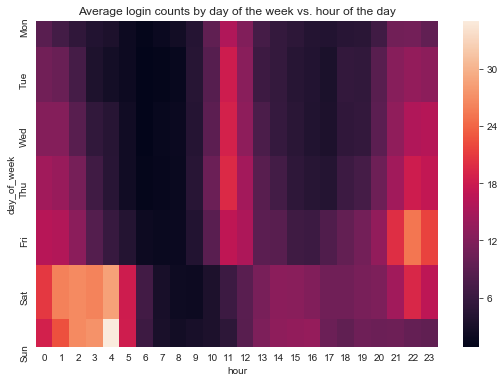

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,8.85,6.9,5.2,3.933333,3.433333,2.016667,1.1,1.85,2.45,4.266667,...,5.616667,4.883333,4.15,3.966667,4.45,4.678571,6.714286,10.803571,10.910714,9.5


In [14]:
# Pivot dataframe to look at differences in intervals by dayofweek and hour
pivot = pd.pivot_table(login, index='day_of_week',columns='hour',values='count',aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(9,6))
ax = sns.heatmap(pivot)
ax.set_title("Average login counts by day of the week vs. hour of the day")
ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.show()
pivot.head(1)

We are able to see a couple different cycles using the heatmap between weekends and weekdays:
- Weekends: There is a clear rise in activity late night on weekends that go into the early day and suddenly die down between 6am and noon.  Then activity remains constant until the night again.
- Weekdays: Activity is dead until the start of business day to beginning of lunch, and then start to lower between end of lunch and end of business day, where there's a small flow of login counts until late night.  Although, we see as each day gets closer to the weekend, login counts steadily rise later into the twilight.

### Trends Over Time

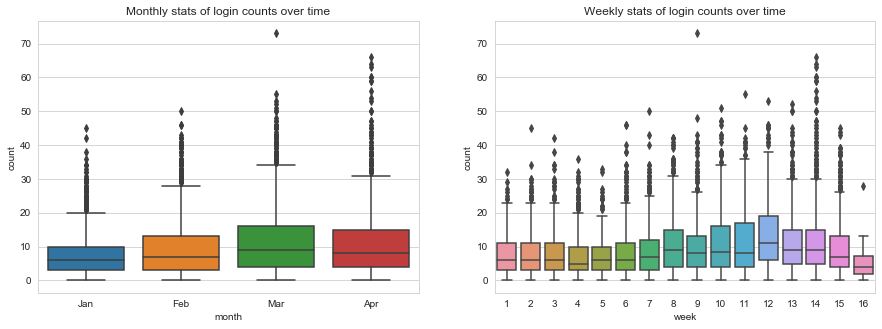

In [15]:
# Plor trends over time
plt.figure(figsize=(15,5))

# Monthly
ax1 = plt.subplot(1,2,1)
sns.boxplot(x='month',y='count',data=login,ax=ax1)
ax1.set_title('Monthly stats of login counts over time')
ax1.set_xticklabels(['Jan','Feb','Mar','Apr'])

# Weekly
ax2 = plt.subplot(1,2,2)
sns.boxplot(x='week',y='count',data=login,ax=ax2)
ax2.set_title('Weekly stats of login counts over time')

plt.show()

There is a steady rise of login counts at 15-minute intervals between January and March, followed by a drop in April.  It is confirmed by the weekly charts, but the drop in April is highlighted to an extreme during the last few weeks.  It's even lower than February, which isn't seen through the monthly charts.  There may be some underlying issue.

# Part 2. Experiment and Metrics Design


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    - how you will implement the experiment.
    - what statistical test(s) you will conduct to verify the significance of the observation.
    - how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

**Find the two groups of driver partners**
- Driver partners exclusive to Metropolis.
- Driver partners exclusive to Gotham.

**Key measure of success**
- Increased time spent in Metropolis by drivers normally exclusive to Gotham.
- Increased time spent in Gotham by drivers normally exclusive to Metropolis.
- Making sure a switch doesn't occur (Metropolis drivers become exclusive to Gotham and vice versa).

**Reasoning**
- Is effective in measuring whether or not both of the driver partners are serving both cities and not just one or neither, which is the ultimate goal of the experiment.
- Easy to implement and simplest measure.

**What's Needed**
- The toll stations at the toll bridge must keep record from each toll, the date, timestamp and vehicle/driver registration (plate and/or license).  This way we can determine when a driver left one city and entered the other, and then returned to the city of origin (time spent crossed-over).  We can subtract the timestamp of the returning toll from the timestamp of the exit toll.  For example:
    - Driver A left Gotham and entered Metropolis at x-time.  Then return from Metropolis to Gotham at x-time.

**Positives**
- This metric is easy to record, track, is low cost and is simple.  The agreement of the driver is not needed for participation and there is no cost for installation of tracking equipment within driver partner cars.

**Negatives**
- This metric only tracks time spent, which can equate to attempt of business; not actual business (tracking pickups and dropoffs), breaks, personal time (driver partners could be Uber drivers who are just visiting for fun) or a mixture of all.  Perhaps, a driver partner's car broke down and it took time to repair.  That's false information of time spent.

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

**How you will implement the experiment?**

- We divide the driver partners into two groups based on the city that they spend the most time in.  As mentioned above, the drivers currently are mostly exclusive to one of the two cities.  Toll records could help in showing which driver spends more time in Gotham (group A) and which drivers spend more time in Metropolis (group B).


- We set up a control group and an experimental group.  Half of all drivers from group A and group B are randomly chosen to be in the control group and the remaining will be in the experimental group.  The experimental group will be given toll passes, or reimbursement offers, for the length of the experiment; but will not be asked to go to the other city.  It is a matter of free will.


- We observe the toll records for the length of the experiment and examine whether the statistics of the experimental group is significantly different than the statistics of the control group when it comes to spending time in the opposite city, due to toll reimbursements/passes.

**What statistical test(s) you will conduct to verify the significance of the observation?**

A/B testing will be conducted, allowing us to evaluate the key metric for each group, comparing the experimental group with the control group.  The toll reimbursement/pass will be the only variable in the test.  This allows for testing within various days of the week, hours in the day, weeks in the month and various weather conditions.

After enough data is collected, we will compute a two-sample t-statistic to determine if the average time drivers spend in their non-associated city is significantly different between the experimental group and the control group.

|A/B Testing| |
|----------------------|----|
|Significance level: |0.05|
|Null hypothesis is: |$$H_0: \mu_(experiment) - \mu_(control) = 0$$|
|Alternative hypothesis is: |$$H_a: \mu_(experiment) - \mu_(control) > 0$$|

We will compute the t-statistics and use $t$ table to find the p-value and draw conclusion.

**How you would interpret the results and provide recommendations to the city operations team along with any caveats:**

Interpreting the results depends on the p-value concluded from the t-tests for each group.  If the p-value is smaller than the significance level for both group A and group B, the experiment and results, along with the confidence level and power of the statistical tests should be presented to the city operation team in order to make an informed decision on whether to implement the toll reimbursement strategy or not.

Potential caveats are:
- *The difference is only significant during weekdays, but not on weekends.*  This is a possibility because there is much activity in both cities during the weekends and drivers can stay busy in one city without having to cross into the other.


- *The difference is only significant in one group, but not the other group.*  This is a possibiity because Gotham is busy at night and without a toll, drivers may be inclined to enter Metropolis during the day to obtain riders.  While Metropolis is more active during the day and drivers may not need, want or be willing to go to Gotham at night and may choose to be at home with family.  It can also work in reverse as well.

# Part 3. Predictive Modeling 
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


## Import and Wrangle Data

In [24]:
# Read in new data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
users = pd.DataFrame(data)

In [25]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


There are three columns with missing data, `phone`, which is categorical, and `avg_rating_of_driver` & `avg_rating_by_driver`, which are numerical.  We may look to drop or fill the missing data.  We also need to convert the columns relating to dates into a datetime format.

In [26]:
# Convert date columns to datetime format
users['signup_date'] = pd.to_datetime(users.signup_date, format='%Y-%m-%d')
users['last_trip_date'] = pd.to_datetime(users.last_trip_date, format='%Y-%m-%d')

In [32]:
# Observe categorical columns
print("---\n",users.city.value_counts(dropna=False))
print("---\n",users.phone.value_counts(dropna=False))
print("---\n",users.ultimate_black_user.value_counts(dropna=False))

---
 Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64
---
 iPhone     34582
Android    15022
N/A          396
Name: phone, dtype: int64
---
 False    31146
True     18854
Name: ultimate_black_user, dtype: int64


In [31]:
# Observe numerical columns
users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Some of the max values are much larger than the average, so we will impute median values for the missing data in the numerical columns.

In [29]:
# Fill missing data to N/A under phone column (categorical)
users.phone = users.phone.fillna('N/A')

# Fill missing data for avg_rating_of_driver and avg_rating_of_driver columns (numerical)
users['avg_rating_by_driver'] = users.avg_rating_by_driver.fillna(users.avg_rating_by_driver.median())
users['avg_rating_of_driver'] = users.avg_rating_of_driver.fillna(users.avg_rating_of_driver.median())

#### Find the fraction of retained users
Since the data was pulled on 2014-07-01, we will consider 'retained' as being if a user made a trip within 30 days of 2014-07-01.

In [33]:
# Find range for determining retained users
beginning = users.last_trip_date.max() - pd.Timedelta('30 days')
beginning

Timestamp('2014-06-01 00:00:00')

In [34]:
# Find retained users using cutoff range
users['retained'] = users.last_trip_date.apply(lambda x: True if x >= beginning else False)

In [37]:
# Find  the fraction of retained users
fraction = users.retained.sum()/len(users)

'Only {:.2f}% of all users that signed up in January of 2014 are retained 6 months later'.format(fraction*100)

'Only 37.61% of all users that signed up in January of 2014 are retained 6 months later'

## Exploratory Data Analysis

#### Correlating Retained Users and Numericals

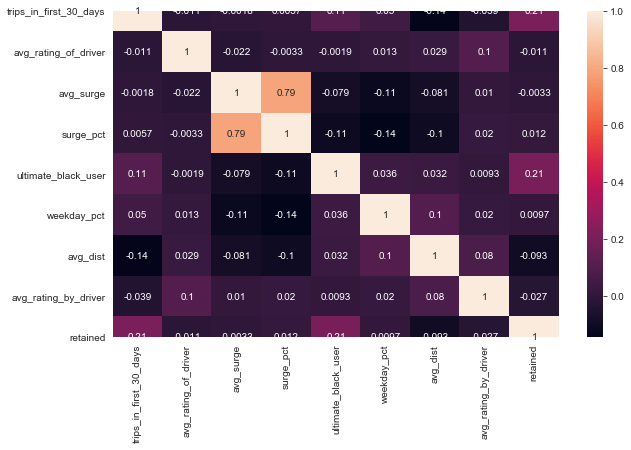

In [54]:
plt.figure(figsize=(10,6))
sns.heatmap(users.corr(),annot=True)

plt.show()

Among numerical columns, trips_in_first_30_days shows the most positive correlation, avg_dist shows the most negative.  Several numerical columns only show minimal correlation, such as avg_rating_by_driver and avg_rating_of_driver columns.

#### Correlating Retained Users and Categories

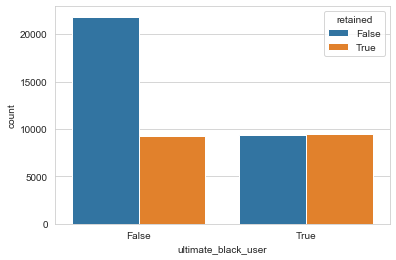

In [56]:
# Correlation between retained and ultimate_black_users
sns.countplot(x='ultimate_black_user', data=users, hue='retained')

plt.show()

Ultimate black users have a higher retention rate than non-ultimate black users.

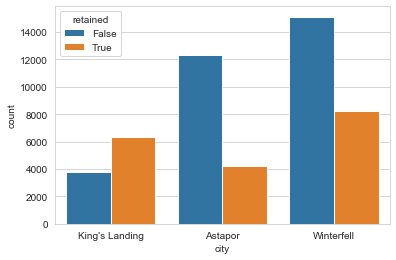

In [57]:
# Correlation between retained and city
sns.countplot(x='city', data=users, hue='retained')

plt.show()

King's Landing users have the highest retention rate, followed by Winterfell, then Astapor City.

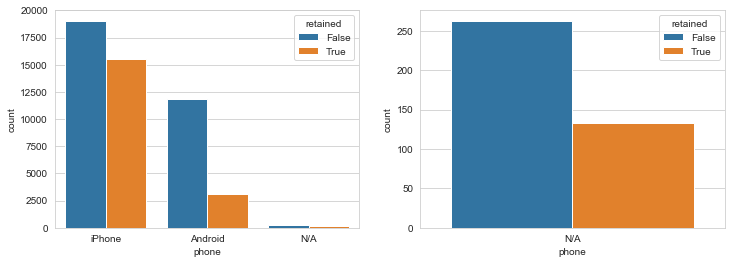

In [58]:
# Correlation between retained and phone
plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,2,1)
sns.countplot(x='phone', data=users, hue='retained',ax=ax1)

ax2 = plt.subplot(1,2,2)
sns.countplot(x='phone', data=users[users.phone == 'N/A'], hue='retained',ax=ax2)

plt.show()

iphone users have a much higher retention rate, 44.9%, than Android users, 20.9%, while the N/A users' rate is 33.6%.

#### Correlating Retained Users and DateTime

signup_date
0    0.387984
1    0.376073
2    0.376645
3    0.360115
4    0.370533
5    0.380453
6    0.384687
Name: retained, dtype: float64


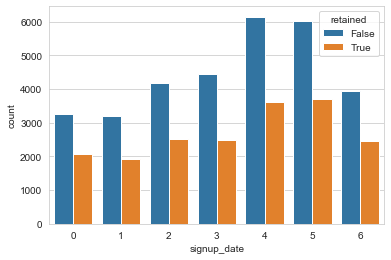

In [60]:
# Correlation between retained and day of the week the user signed up
sns.countplot(x=users.signup_date.dt.dayofweek, data=users, hue='retained')
print(users.groupby(users.signup_date.dt.dayofweek)['retained'].mean())

signup_date
1    0.413005
2    0.377241
3    0.358766
4    0.374445
5    0.370746
Name: retained, dtype: float64


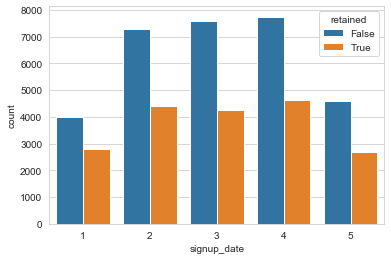

In [61]:
# Correlation between retained and week of the month the user signed up
sns.countplot(x=users.signup_date.dt.week, data=users, hue='retained')
print(users.groupby(users.signup_date.dt.week)['retained'].mean())

# Add signup_week as a new featue and drop the original signup_date column
users['signup_week'] = users.signup_date.dt.week.astype('category')
users = users.drop('signup_date',axis=1)

There's little correlation between retained users and day of the week they signed up so the feature is not needed.  However, there's some correlation between retained users and the week in January they signed up so a new feature is added and signup_date will be dropped.

last_trip_date
0    0.438352
1    0.381611
2    0.328779
3    0.340780
4    0.359635
5    0.371874
6    0.389008
Name: retained, dtype: float64


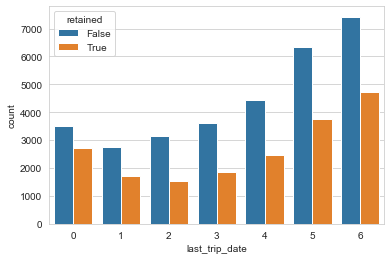

In [62]:
# Correlation between retained and day of the week of the user's last trip
sns.countplot(x=users.last_trip_date.dt.dayofweek, data=users, hue='retained')
print(users.groupby(users.last_trip_date.dt.dayofweek)['retained'].mean())

# Add lasttrip_dayofweek as a new featue
users['lasttrip_dayofweek'] = users.last_trip_date.dt.dayofweek.astype('category')

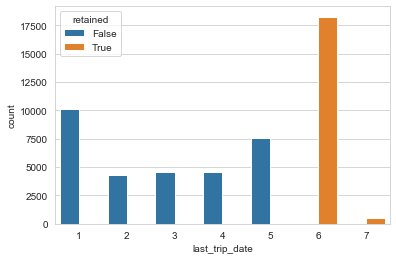

In [63]:
# Correlation between retained and the month of the user's last trip
sns.countplot(x=users.last_trip_date.dt.month, data=users, hue='retained')

# Drop original last_trip_date column
users = users.drop('last_trip_date',axis=1)

There's some correlation between retained users and which day of the week the user's last trip occured so a new fewature is added.  Retained users are correlated to the month of the last trip taken but a feature is not taken because it is already known between 2014-06-01 and 2014-07-01 so last_trip_date can be dropped.

## Modeling

To predict user adoption of the product, three different classification algorithms are experimented: 
- Logistic Regression (linear)
- Support Vector Machine (non-linear)
- Gradient Boosting (ensemble)

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [68]:
# Create dummy variables from categorical columns and extract features X and target y
X = pd.get_dummies(users.drop('retained',axis=1), drop_first=True)
y = users.retained

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [69]:
# Create evaluation table
index = ['LogisticRegression','SVC','GradientBoostingClassifier']

eval_table = pd.DataFrame(
    index = index, 
    columns= ['accuracy_train','f1_score_train','accuracy_test','f1_score_test'])

# Define function for plotting results
def compute_result(algorithm, pred_train, pred_test):
    """compute and log the performance for both training and test sets"""
    
    # compute the performance  
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    # log the performance
    eval_table.loc[algorithm,:] = accuracy_train, f1_train, accuracy_test, f1_test
    
    # compute confusion matrix and print
    print('Classification results from the test set:\n', classification_report(y_test, pred_test))

In [70]:
# Fit default logistic regression model
logreg = Pipeline([('scaler', StandardScaler()),('logreg', LogisticRegression())])
logreg.fit(X_train, y_train)
pred_train = logreg.predict(X_train)
pred_test = logreg.predict(X_test)

# Record model performance
compute_result('LogisticRegression', pred_train, pred_test)

                   feature  coefficient
8      city_King's Landing     0.705995
11            phone_iPhone     0.500140
0   trips_in_first_30_days     0.451293
4      ultimate_black_user     0.429166
9          city_Winterfell     0.274178
5              weekday_pct     0.096055
3                surge_pct     0.084613
10               phone_N/A     0.034276
21    lasttrip_dayofweek_6    -0.007713
1     avg_rating_of_driver    -0.040398
2                avg_surge    -0.051839
16    lasttrip_dayofweek_1    -0.068286
7     avg_rating_by_driver    -0.072257
20    lasttrip_dayofweek_5    -0.090582
14           signup_week_4    -0.097920
12           signup_week_2    -0.098909
15           signup_week_5    -0.103114
19    lasttrip_dayofweek_4    -0.123168
18    lasttrip_dayofweek_3    -0.128127
13           signup_week_3    -0.136727
17    lasttrip_dayofweek_2    -0.144062
6                 avg_dist    -0.215493
Classification results from the test set:
               precision    recall  f1

In [71]:
# Fit default support vector machine model
svc = Pipeline([('scaler', StandardScaler()),('svc', SVC())])
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

# Record model performance
compute_result('SVC', pred_train, pred_test)

Classification results from the test set:
               precision    recall  f1-score   support

       False       0.78      0.86      0.82      7799
        True       0.72      0.59      0.65      4701

    accuracy                           0.76     12500
   macro avg       0.75      0.73      0.73     12500
weighted avg       0.75      0.76      0.75     12500



In [73]:
# Fit default gradient bossting model

gbc = Pipeline([('scaler', StandardScaler()),('gbc', GradientBoostingClassifier())]) 
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

# Record model performance
compute_result('GradientBoostingClassifier', pred_train, pred_test)

                   feature  importance
7     avg_rating_by_driver    0.246560
8      city_King's Landing    0.173041
3                surge_pct    0.164584
5              weekday_pct    0.163993
11            phone_iPhone    0.088956
4      ultimate_black_user    0.069455
0   trips_in_first_30_days    0.043274
9          city_Winterfell    0.016944
6                 avg_dist    0.015819
1     avg_rating_of_driver    0.009514
2                avg_surge    0.004035
21    lasttrip_dayofweek_6    0.001813
20    lasttrip_dayofweek_5    0.000837
10               phone_N/A    0.000562
13           signup_week_3    0.000283
17    lasttrip_dayofweek_2    0.000175
19    lasttrip_dayofweek_4    0.000091
12           signup_week_2    0.000066
14           signup_week_4    0.000000
15           signup_week_5    0.000000
16    lasttrip_dayofweek_1    0.000000
18    lasttrip_dayofweek_3    0.000000
Classification results from the test set:
               precision    recall  f1-score   support

     

In [75]:
# Show results of each model's performance
eval_table

,accuracy_train,f1_score_train,accuracy_test,f1_score_test
LogisticRegression,0.722187,0.576538,0.7188,0.569082
SVC,0.780133,0.67711,0.7588,0.647657
GradientBoostingClassifier,0.788667,0.703017,0.79,0.70654


These results are all terrible, so we will add a fourth classification algorithm.
- Random Forest (ensemble)

In [79]:
from sklearn.ensemble import RandomForestClassifier
# Fit default random forest model

# Set class_weight to 'balanced' to adjust for the imbalanced classes
rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(class_weight='balanced'))]) 
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

# Record model performance
compute_result('RandomForestClassifier', pred_train, pred_test)

Classification results from the test set:
               precision    recall  f1-score   support

       False       0.77      0.86      0.82      7799
        True       0.72      0.58      0.64      4701

    accuracy                           0.76     12500
   macro avg       0.75      0.72      0.73     12500
weighted avg       0.75      0.76      0.75     12500



In [78]:
eval_table

,accuracy_train,f1_score_train,accuracy_test,f1_score_test
LogisticRegression,0.722187,0.576538,0.7188,0.569082
SVC,0.780133,0.67711,0.7588,0.647657
GradientBoostingClassifier,0.788667,0.703017,0.79,0.70654
RandomForestClassifier,0.983147,0.977237,0.75968,0.646172


### Optimizing Gradient Boosting through Hypertuning
Gradient Boosting has the best f1 score and accuracy.  We will hypertune this model to see what gives us the best performance.

In [82]:
# Use gridsearchcv to optimize the GradientBoostingClassifier

parameters = {'gbc__n_estimators': np.arange(400,1000,100), 'gbc__max_features':[None,'sqrt','log2']}
gbc_cv = GridSearchCV(gbc, parameters, scoring='accuracy', cv=5)
gbc_cv.fit(X_train, y_train)

print('Best parameters:', gbc_cv.best_params_)
print('Corresponding accuracy score:', gbc_cv.best_score_)

Best parameters: {'gbc__max_features': None, 'gbc__n_estimators': 600}
Corresponding accuracy score: 0.7917333333333333


In [84]:
# Hypertuned GradientBoostingClassifier
gbc = Pipeline([('scaler', StandardScaler()),
                ('gbc', GradientBoostingClassifier(n_estimators=600, 
                                                   max_features=None))])
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

compute_result('GradientBoostingClassifier', pred_train, pred_test)

Classification results from the test set:
               precision    recall  f1-score   support

       False       0.81      0.87      0.84      7799
        True       0.75      0.67      0.71      4701

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500



In [94]:
# Feature importance ranking of hypertuned GradientBoostingClassifier 
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbc.named_steps.gbc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False)[:3])

# Final result
pd.DataFrame(eval_table.loc[['GradientBoostingClassifier']])

                feature  importance
7  avg_rating_by_driver    0.229261
5           weekday_pct    0.171160
3             surge_pct    0.158708


,accuracy_train,f1_score_train,accuracy_test,f1_score_test
GradientBoostingClassifier,0.807013,0.728412,0.7928,0.708989


The hypertuned GradientBoostingClassifier gives the best accuracy score and F1 score among all. The features that are most important in the classifiers prediction of retention are shown above (average rating by driver, percentage of weekday trips and percentage of surge multiplier trips). 

## Conclusion
### Improving Long-Term Rider Retention

- Check if Android apps have another competitor or if they are failing through bugs or user experience.

- Discounts for Astaphor and Winterfell residents, contingent to using every xx amount of trips.

- Marketing campaigns (promotions) for users who take intermediate trips, promoting weekday travel during surge pricing. Random selection to get rid of surge pricing every xx amount of trips.